# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import json
import glob
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.memory", "4g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2020-03-27 00:35 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-03-27 00:35 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-03-27 00:35 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-03-27 00:35 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-03-27 00:35 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2020-03-27 10:30 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2020-03-27 00:35 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-03-27 00:35 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-03-27 00:35 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-03-27 00:35 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 31.6 ms, sys: 5.87 ms, total: 37.4 ms
Wall time: 2min 40s


162541

Сохраним датасет в память

In [12]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 39.2 ms, sys: 7.36 ms, total: 46.6 ms
Wall time: 4min 11s


162541

Количество фильмов

In [14]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [15]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [16]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(196959, (5.0, ['196959', 'I Am JFK Jr. (2016)'])),
 (180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (188573, (5.0, ['188573', 'Judy (2014)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
# movie_avg_rating\
#     .repartition(10) \
#     .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
!hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-03-27 10:30 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58903 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112361 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131524 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114377 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133576 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117783 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143242 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     131984 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167729 2020-03-27 10:30 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

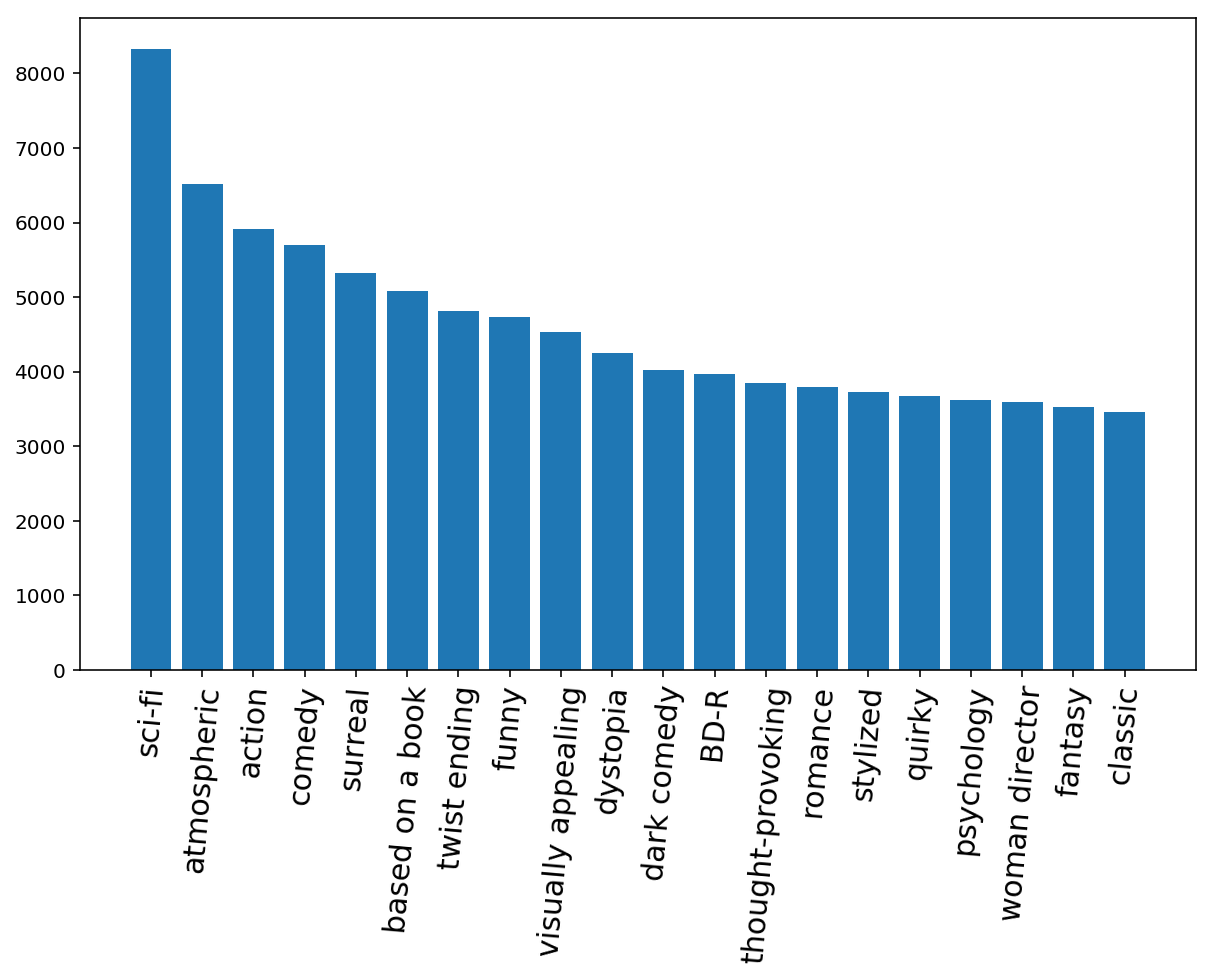

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
id_ratings = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)


id_ratings \
    .join(movies) \
    .map(lambda r: (r[0], r[1][0], r[1][1][1])) \
    .sortBy(lambda r: r[1], ascending=False) \
    .take(10)

[(356, 81491, 'Forrest Gump (1994)'),
 (318, 81482, '"Shawshank Redemption'),
 (296, 79672, 'Pulp Fiction (1994)'),
 (593, 74127, '"Silence of the Lambs'),
 (2571, 72674, '"Matrix'),
 (260, 68717, 'Star Wars: Episode IV - A New Hope (1977)'),
 (480, 64144, 'Jurassic Park (1993)'),
 (527, 60411, "Schindler's List (1993)"),
 (110, 59184, 'Braveheart (1995)'),
 (2959, 58773, 'Fight Club (1999)')]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
id_ratings5 = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: a + b)

id_ratings5 \
    .join(movies) \
    .map(lambda r: (r[0], r[1][0], r[1][1][1])) \
    .sortBy(lambda r: r[1], ascending=False) \
    .take(10)

[(318, 39553, '"Shawshank Redemption'),
 (296, 32169, 'Pulp Fiction (1994)'),
 (356, 25918, 'Forrest Gump (1994)'),
 (260, 25804, 'Star Wars: Episode IV - A New Hope (1977)'),
 (2571, 25482, '"Matrix'),
 (527, 24853, "Schindler's List (1993)"),
 (593, 24801, '"Silence of the Lambs'),
 (858, 24418, '"Godfather'),
 (50, 21585, '"Usual Suspects'),
 (2959, 21486, 'Fight Club (1999)')]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

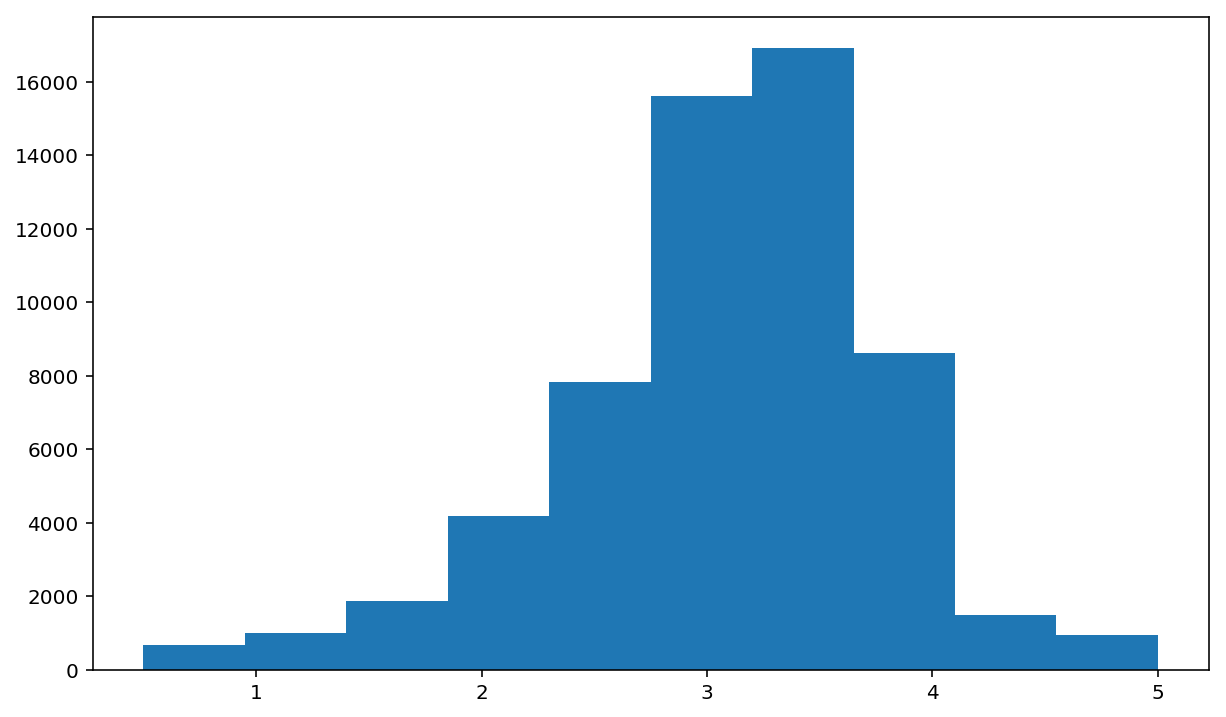

In [26]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(movie_avg_rating.values().collect())
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

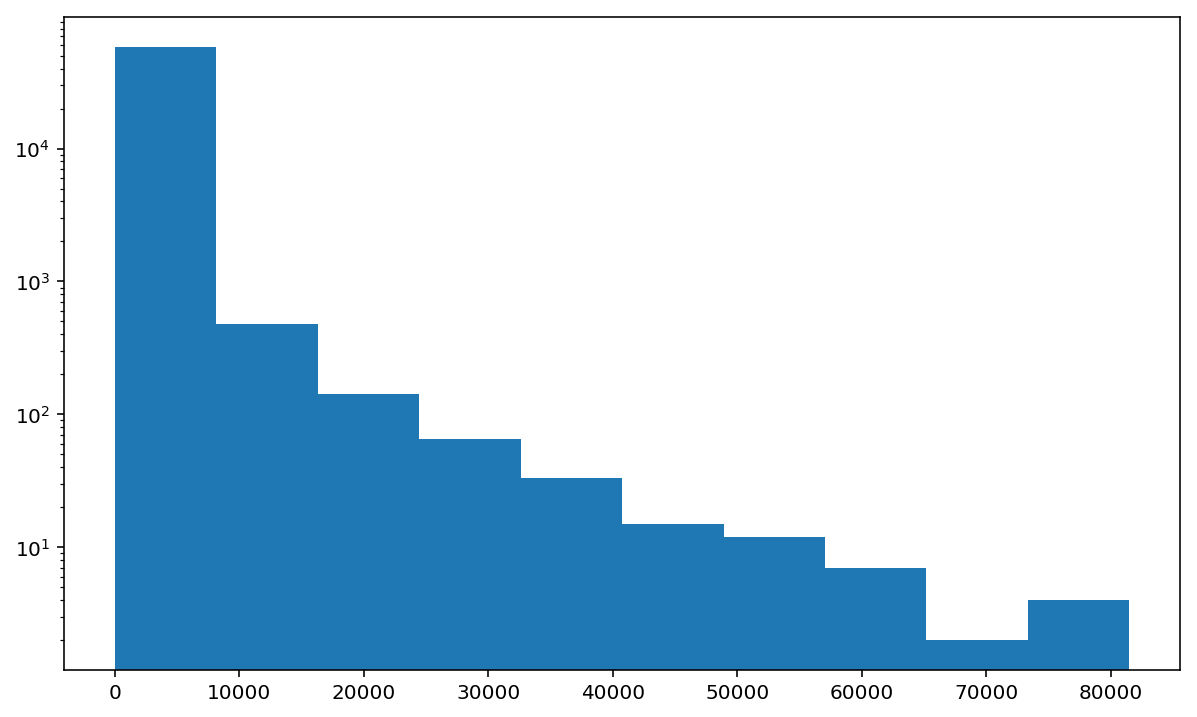

In [27]:
f, ax = plt.subplots(figsize=(10, 6))
plt.hist(id_ratings.values().collect(), log=True)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [42]:
movies_all = sc.textFile(MOVIES_PATH)
header = movies_all.take(1)[0]
header

'movieId,title,genres'

In [51]:
id_genre = movies_all \
    .filter(lambda r: r != header) \
    .map(lambda r: r.split(',')) \
    .flatMap(lambda r: [(int(r[0]), s) for s in r[2].split('|')]) \
    .filter(lambda r: not r[1].strip().startswith('A')) \
    .filter(lambda r: not r[1].strip().startswith('The')) \
    .filter(lambda r: r[1] != '(no genres listed)')

id_genre.take(10)

[(1, 'Children'),
 (1, 'Comedy'),
 (1, 'Fantasy'),
 (2, 'Children'),
 (2, 'Fantasy'),
 (3, 'Comedy'),
 (3, 'Romance'),
 (4, 'Comedy'),
 (4, 'Drama'),
 (4, 'Romance')]

In [30]:
genre_num = id_genre \
    .map(lambda r: (r[1], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda r: r[1], ascending=False)

genre_num.take(10)

[('Drama', 22111),
 ('Comedy', 14831),
 ('Thriller', 7645),
 ('Romance', 6718),
 ('Action', 6678),
 ('Horror', 5361),
 ('Documentary', 5083),
 ('Crime', 4615),
 ('Adventure', 3558),
 ('Sci-Fi', 3261)]

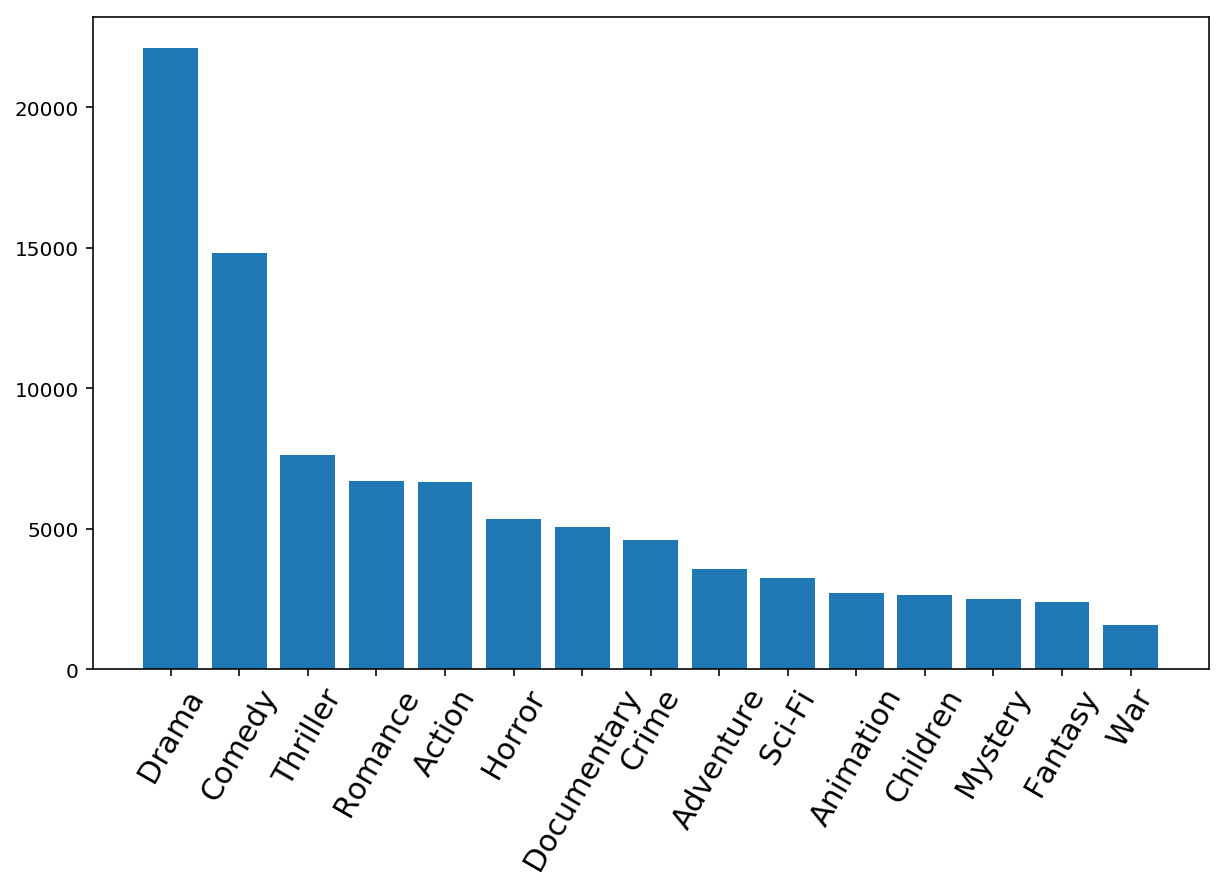

In [31]:
f, ax = plt.subplots(figsize=(10, 6))
plt.bar(*zip(*genre_num.take(15)))
plt.xticks(rotation=60, fontsize=15)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [32]:
links_all = sc.textFile(LINKS_PATH)
header = links_all.take(1)[0]
header

'movieId,imdbId,tmdbId'

In [33]:
tid_id = links_all \
    .filter(lambda r: r != header) \
    .map(lambda r: r.split(',')) \
    .filter(lambda r: r[0].isdigit() and r[2].isdigit()) \
    .map(lambda r: (int(r[2]), int(r[0])))

tid_id.take(10)

[(862, 1),
 (8844, 2),
 (15602, 3),
 (31357, 4),
 (11862, 5),
 (949, 6),
 (11860, 7),
 (45325, 8),
 (9091, 9),
 (710, 10)]

In [34]:
def parse(r):
    r_json = json.loads(r)

    if 'id' in r_json:
        return (r_json['id'], r)


tid_tmdb = sc \
    .textFile(TMDB_PATH) \
    .map(parse) \
    .filter(lambda r: r is not None)

id_tmdb = tid_id \
    .join(tid_tmdb) \
    .values()

In [35]:
def parse_cast(r):
    id_, r = r[0], json.loads(r[1])

    cast = r['casts']['cast']
    return (id_, [(c['id'], c['name']) for c in cast])


id_personid1person = id_tmdb \
    .map(parse_cast) \
    .flatMap(lambda r: [(r[0], p[0], p[1]) for p in r[1]])

id_personid1person.take(10)

[(139735, 1824648, 'Ben Kobold'),
 (139735, 1222643, 'David Liebe Hart'),
 (147308, 550738, 'Aleksandr Lyapin'),
 (147308, 550739, 'Lidiya Milyuzina'),
 (147308, 550740, 'Egor Baranovsky'),
 (147308, 550741, 'Ivan Kupreyenko'),
 (147308, 240563, 'Vladimir Ilin'),
 (147308, 238525, 'Tatyana Yakovenko'),
 (147308, 1341809, 'Armen Dzhigarkhanyan'),
 (174261, 89518, 'Mack Sennett')]

#### 1

In [36]:
movies \
    .join(id_personid1person.filter(lambda r: r[1] == 31)) \
    .values() \
    .map(lambda r: r[0][1]) \
    .collect()

['Sleepless in Seattle (1993)',
 '"Celluloid Closet',
 '"\'burbs',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 'Elvis Has Left the Building (2004)',
 '"League of Their Own',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie',
 'Larry Crowne (2011)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'Radio Flyer (1992)',
 'California Typewriter (2017)',
 'Apollo 13 (1995)',
 '"Pixar Story',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"Ladykillers',
 '

#### 2

In [37]:
id_personid1person \
    .map(lambda r: (r[2], 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .sortBy(lambda r: r[-1], ascending=False) \
    .keys() \
    .take(10)

['Bess Flowers',
 'Frank Welker',
 'Christopher Lee',
 'Clarence Nash',
 'Irving Bacon',
 'John Carradine',
 'John Wayne',
 'Mel Blanc',
 'Samuel L. Jackson',
 'Eric Roberts']

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [52]:
def parse_year(r):
    id_, r = r[0], json.loads(r[1])

    if len(r['release_date'].split('-')[0]):
        return (id_, int(r['release_date'].split('-')[0]))


id_year = id_tmdb \
    .map(parse_year) \
    .filter(lambda r: r is not None)

id_year.take(10)

[(139735, 2014),
 (147308, 2008),
 (174261, 1909),
 (8921, 1955),
 (923, 1941),
 (6770, 2003),
 (148805, 2014),
 (159692, 2008),
 (206785, 2016),
 (40278, 2005)]

In [53]:
year_genre1num = id_genre \
    .join(id_year) \
    .values() \
    .map(lambda r: (r, 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .filter(lambda r: r[1] > 5) \
    .map(lambda r: (r[0][1], (r[0][0], r[1])))

year_genre1num.take(10)

[(1983, ('Comedy', 129)),
 (1936, ('Crime', 22)),
 (1994, ('Mystery', 15)),
 (2005, ('Thriller', 170)),
 (1943, ('Musical', 13)),
 (1946, ('Musical', 7)),
 (1965, ('Horror', 23)),
 (1968, ('Horror', 26)),
 (1986, ('Crime', 36)),
 (1982, ('War', 9))]

In [54]:
years = year_genre1num.keys().distinct().sortBy(lambda r: r).collect()
genres = year_genre1num.values().map(lambda r: r[0]).distinct().sortBy(lambda r: r).collect()
print(*years)
print(*genres)

1894 1895 1896 1898 1903 1906 1907 1908 1909 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
Children Comedy Crime Documentary Drama Fantasy Film-Noir Horror IMAX Musical Mystery Romance Sci-Fi Thriller War Western


In [55]:
data = np.zeros((len(genres), len(years)))
for year, (genre, num) in year_genre1num.collect():
    data[genres.index(genre), years.index(year)] += num
data /= data.sum(axis=0)

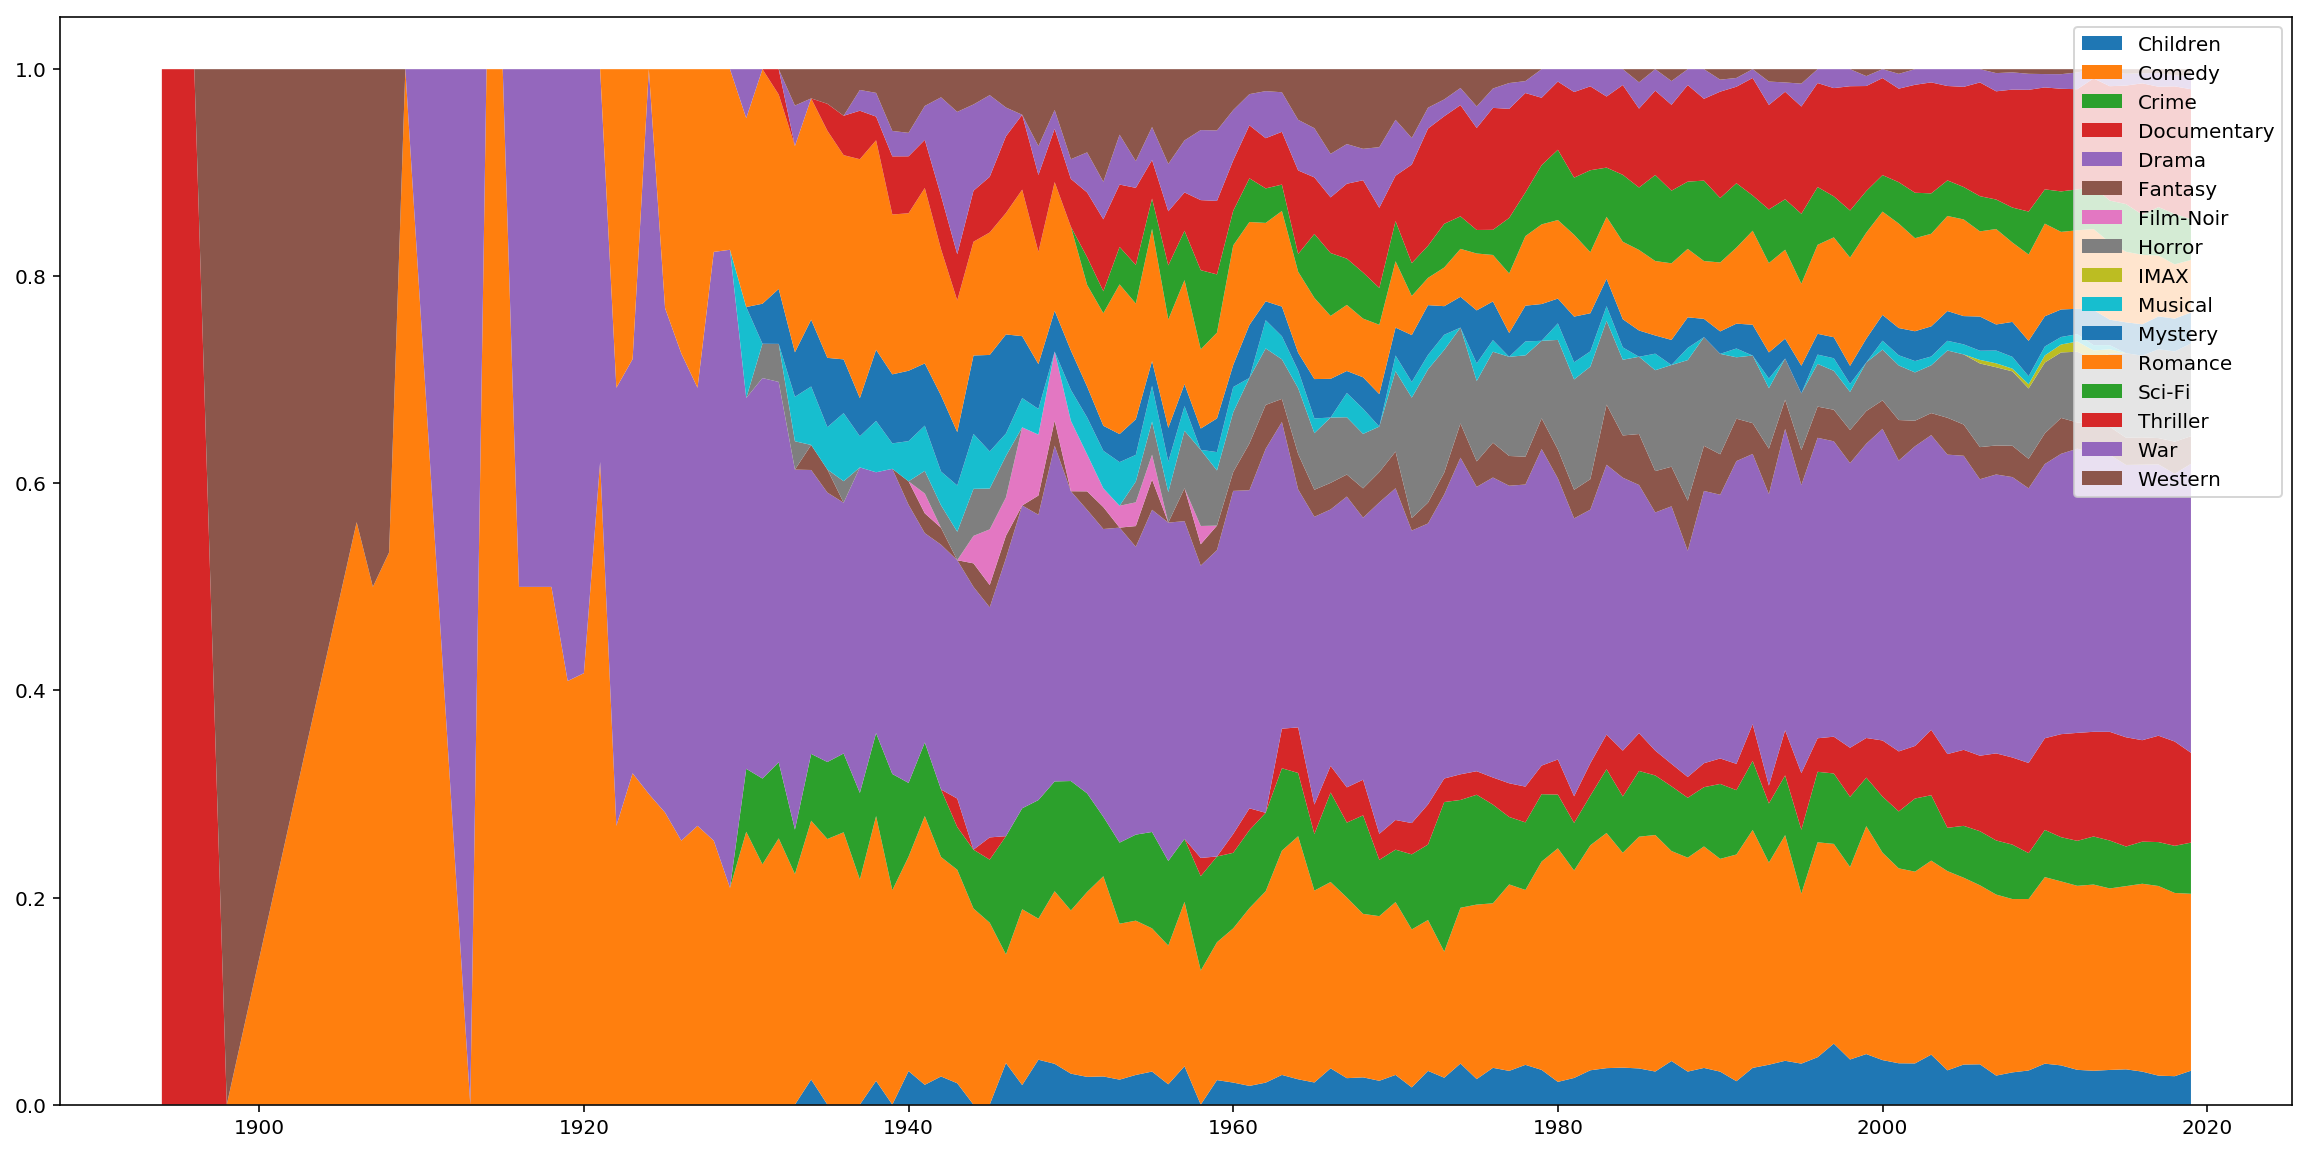

In [56]:
f, ax = plt.subplots(figsize=(20, 10))
plt.stackplot(years, data)
plt.legend(genres)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [57]:
def parse_revenue_budget(r):
    id_, r = r[0], json.loads(r[1])

    return (id_, (int(r['revenue']), int(r['budget'])))


id_revenue1budget = id_tmdb \
    .map(parse_revenue_budget) \
    .filter(lambda r: (r[1][0] != 0) and (r[1][1] != 0))

id_revenue1budget.take(10)

[(923, (23217674, 839727)),
 (40278, (96889998, 72000000)),
 (18, (4257354, 4000000)),
 (54272, (527068851, 75000000)),
 (184741, (15500000, 7154497)),
 (4235, (20908467, 2000000)),
 (5810, (242875078, 41000000)),
 (30707, (216763646, 30000000)),
 (1391, (101371017, 70000000)),
 (8638, (15992615, 2700000))]

In [58]:
genre_roi = id_genre \
    .join(id_revenue1budget) \
    .map(lambda r: (r[1][0], r[1][1] + (1,))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1], a[2] + b[2])) \
    .filter(lambda r: r[1][-1] > 30) \
    .map(lambda r: (r[0], r[1][0] / r[1][1])) \
    .sortBy(lambda r: r[1], ascending=False)

genre_roi.take(10)

[('Musical', 3.52277467879752),
 ('IMAX', 3.5113972427094295),
 ('Documentary', 3.3843579982146563),
 ('Children', 3.3291997560353583),
 ('Romance', 3.2941355202081573),
 ('Horror', 3.1959638559421037),
 ('Sci-Fi', 3.1800291897917368),
 ('Fantasy', 3.1384939983294986),
 ('Comedy', 3.124316223182482),
 ('Thriller', 2.7649428596962435)]

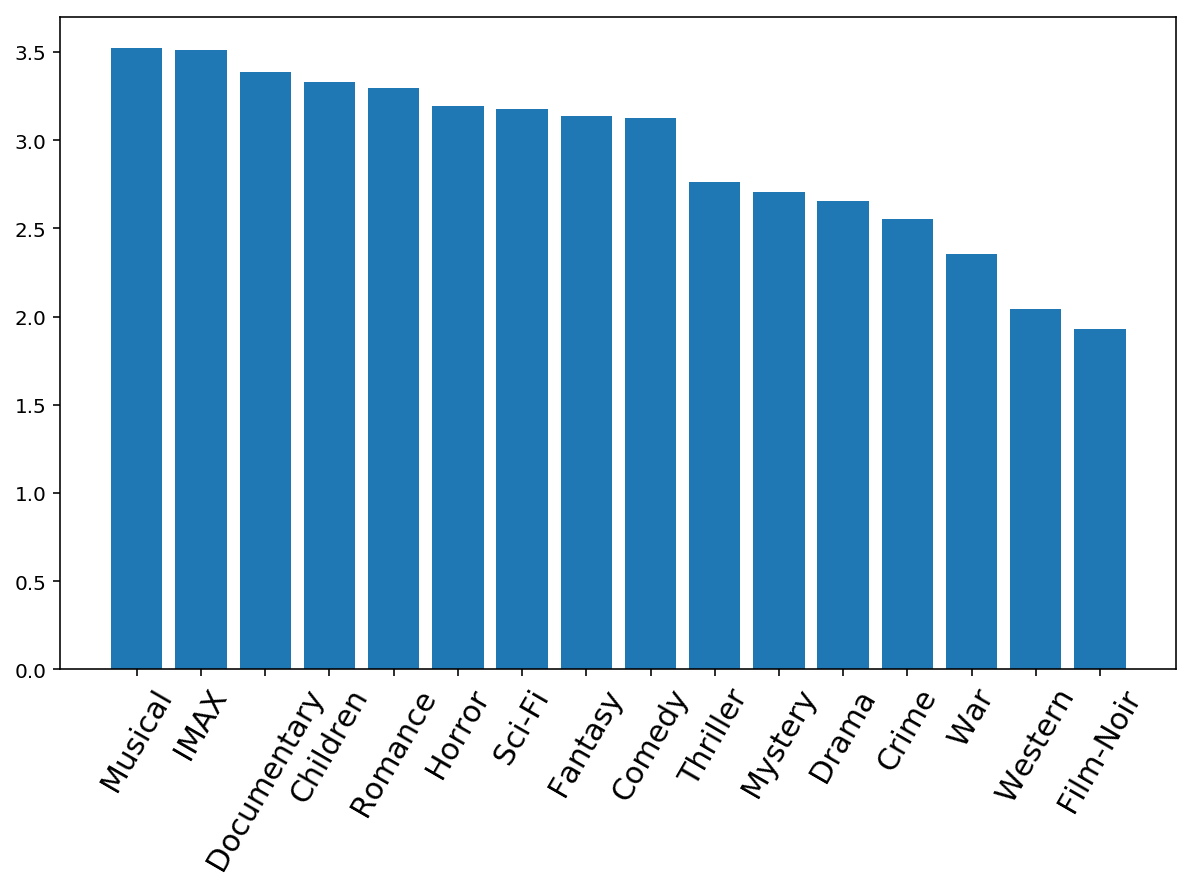

In [59]:
f, ax = plt.subplots(figsize=(10, 6))
plt.bar(*zip(*genre_roi.take(20)))
plt.xticks(rotation=60, fontsize=15)
plt.show()